# Add Ingress-Nginx controler to HPCC TLS with multiple services

Use a dynamic public IP address to create an HTTPS ingress-nginx controller on Azure Kubernetes Service.

An ingress controller is a piece of software that provides reverse proxy, configurable traffic routing, and TLS termination for Kubernetes services. Kubernetes ingress resources are used to configure the ingress rules and routes for individual Kubernetes services. Using an ingress controller and ingress rules, a single IP address can be used to route traffic to multiple services in a Kubernetes cluster.

This example shows you how to deploy the NGINX ingress controller in an Azure Kubernetes Service cluster. The cert-manager project is used to automatically generate and configure Let's Encrypt certificates. Finally, an application is run in the cluster, accessible over a single host-name (FQDN).

## Prerequisites
* Install [Cert-Manager](https://github.com/amy88ma/Ingress-Configuration/blob/aab78ac2423763a179779001f74f52680213fcbc/Jupyter%20Notebooks/Install_cert-manager.ipynb).

Install cert-manager to do the work with Kubernetes to request a certificate and respond to the challenge to validate it. You can use Helm or plain Kubernetes manifest to install cert-manager.

* Install [Helm](https://github.com/amy88ma/Ingress-Configuration/blob/50c510778e326ece24d8364f3e897d0e17d30bc4/Jupyter%20Notebooks/Install_helm.ipynb).

Helm is used to deploy the HPCC chart, and create the ingress-nginx controller in this example.
* Create the [nginx controller](https://github.com/amy88ma/Ingress-Configuration/blob/1c938e0115d2f8c0a08da98a1b32c1e1a8aa0085/Jupyter%20Notebooks/Install_nginx.ipynb).

A kubernetes ingress controller is designed to be the access point for HTTP and HTTPS traffic to the software running within your cluster. The ingress-nginx-controller does this by providing an HTTP proxy service supported by your cloud provider’s load balancer.

* Have the [HPCC helm chart deployed](https://github.com/amy88ma/Ingress-Configuration/blob/fc302293ddbfd7ba7ca60b2b335e4881768fdd7f/Deployment/Deploy_HPCC.ipynb).

## Add a record to DNS zone 

In [1]:
kubectl --namespace default get services -o wide -w ingress-nginx-controller

NAME                       TYPE           CLUSTER-IP    EXTERNAL-IP    PORT(S)                      AGE   SELECTOR
ingress-nginx-controller   LoadBalancer   10.0.10.134   20.75.59.121   80:31182/TCP,443:30234/TCP   19m   app.kubernetes.io/component=controller,app.kubernetes.io/instance=ingress-nginx,app.kubernetes.io/name=ingress-nginx


1. Using the above command to get the External-IP of the ingress-nginx controller, configure an FQDN-- Fully Qualified Domain Name -- for the ingress controller IP address.  In the following example, the IP address is as follows:

In [ ]:
IP="20.75.59.121"

2. Then, create a DNS name, to associate with the public IP address.  This example creates a DNS name called 'hpcc-ingress':

The external IP that is allocated to the ingress-controller is the IP to which all incoming traffic should be routed. To enable this, add it to a DNS zone you control.

In [ ]:
DNSNAME="hpcc-ingress"

3. Get the resource-id of the public IP, with the following command:

In [ ]:
PUBLICIPID=$(az network public-ip list --query "[?ipAddress!=null]|[?contains(ipAddress, '20.75.59.121')].[id]" --output tsv)

4. Next, update your public IP address with the previously created DNS name, 'hpcc-ingress':

In [ ]:
az network public-ip update --ids $PUBLICIPID --dns-name $DNSNAME

The following content is the example output of the command used above, in step 4.

In [ ]:
{
  "ddosSettings": null,
  "deleteOption": null,
  "dnsSettings": {
    "domainNameLabel": "hpcc-ingress",
    "fqdn": "hpcc-ingress.eastus2.cloudapp.azure.com",
    "reverseFqdn": null
  },
  "etag": "W/\"1b9b0158-3e9b-4b6f-9d3e-4323467a819e\"",
  "extendedLocation": null,
  "id": "/subscriptions/49219efc-701f-4c7e-a2ac-c600308a69e3/resourceGroups/mc_aks-1nodepool-sa-amy_aks-1nodepool-sa-amy-eastus2_eastus2/providers/Microsoft.Network/publicIPAddresses/kubernetes-a87b5b9c9e0d84ba89b7bcd4c531ed4c",
  "idleTimeoutInMinutes": 4,
  "ipAddress": "20.75.59.121",
  "ipConfiguration": {
    "etag": null,
    "id": "/subscriptions/49219efc-701f-4c7e-a2ac-c600308a69e3/resourceGroups/mc_aks-1nodepool-sa-amy_aks-1nodepool-sa-amy-eastus2_eastus2/providers/Microsoft.Network/loadBalancers/kubernetes/frontendIPConfigurations/a87b5b9c9e0d84ba89b7bcd4c531ed4c",
    "name": null,
    "privateIpAddress": null,
    "privateIpAllocationMethod": null,
    "provisioningState": null,
    "publicIpAddress": null,
    "resourceGroup": "mc_aks-1nodepool-sa-amy_aks-1nodepool-sa-amy-eastus2_eastus2",
    "subnet": null
  },
  "ipTags": [],
  "linkedPublicIpAddress": null,
  "location": "eastus2",
  "migrationPhase": null,
  "name": "kubernetes-a87b5b9c9e0d84ba89b7bcd4c531ed4c",
  "natGateway": null,
  "provisioningState": "Succeeded",
  "publicIpAddressVersion": "IPv4",
  "publicIpAllocationMethod": "Static",
  "publicIpPrefix": null,
  "resourceGroup": "mc_aks-1nodepool-sa-amy_aks-1nodepool-sa-amy-eastus2_eastus2",
  "resourceGuid": "fd1d29b5-43c6-441c-9fed-6b40f1cf7efb",
  "servicePublicIpAddress": null,
  "sku": {
    "name": "Standard",
    "tier": "Regional"
  },
  "tags": {
    "kubernetes-cluster-name": "kubernetes",
    "service": "default/ingress-nginx-controller"
  },
  "type": "Microsoft.Network/publicIPAddresses",
  "zones": [
    "1",
    "2",
    "3"
  ]
}

5. To display the FQDN needed for later to add to the ingress route host name, use the following command:

In [ ]:
az network public-ip show --ids $PUBLICIPID --query "[dnsSettings.fqdn]" --output tsv

The following is the output shown for the command mentioned above.

In [ ]:
hpcc-ingress.eastus2.cloudapp.azure.com

## Create a CA cluster issuer

In order to begin issuing certificates, you will need to set up a ClusterIssuer.  ClusterIssuer works across all namespaces.  Create a cluster issuer, such as *cluster-issuer.yaml*, using the following example manifest. Update the email address with a valid address from your organization.

This email required by Let’s Encrypt and used to notify you of certificate expiration and updates.

In [ ]:
apiVersion: cert-manager.io/v1
kind: ClusterIssuer
metadata:
  name: letsencrypt
spec:
  acme:
    server: https://acme-v02.api.letsencrypt.org/directory
    email: example@email.com # Replace with a valid email
    privateKeySecretRef:
      name: letsencrypt
    solvers:
    - http01:
        ingress:
          class: nginx
          podTemplate:
            spec:
              nodeSelector:
                "kubernetes.io/os": linux

Create the issuer:

In [ ]:
kubectl apply -f cluster-issuer.yaml

The output should look like this:

In [ ]:
clusterissuer.cert-manager.io/letsencrypt created

## Create Ingress route

An ingress controller and a certificate management solution have been configured, applications can be run.  Create a file with the name "hpcc-ingress.yaml"

In [ ]:
apiVersion: networking.k8s.io/v1beta1
kind: Ingress
metadata:
  name: hpcc-ingress
  annotations:
    kubernetes.io/ingress.class: nginx
    nginx.ingress.kubernetes.io/use-regex: "true"
    nginx.ingress.kubernetes.io/rewrite-target: /$1
spec:
  rules:
   - http:
      paths:
      - backend:
          serviceName: eclwatch
          servicePort: 8010
        path: /eclwatch(/|$)(.*)
      - backend:
          serviceName: eclqueries
          servicePort: 8002
        path: /eclqueries(/|$)(.*)
      - backend:
          serviceName: esdl-sandbox
          servicePort: 8899
        path: /esdl(/|$)(.*)
      - backend:
          serviceName: sql2ecl
          servicePort: 8510
        path: /wssql(/|$)(.*)
      - backend:
          serviceName: eclservices
          servicePort: 8010
        path: /(.*)

* ClusterIP service type: Exposes the service on a cluster-internal IP. Choosing this value makes the service only reachable from within the cluster.  The service will be made publicly available in the next step, by creating a kubernetes ingress resource.
* The path names correspond to the respective port numbers.  To test the ingress later, the path names will follow the FQDN, for example:

**hpcc-ingress.eastus2.cloudapp.azure.com/eclwatch**

Apply Ingress route using:

In [ ]:
kubectl apply -f hpcc-ingress.yaml

The output should be similar to:

In [ ]:
ingress.networking.k8s.io/hpcc-ingress created

## Upgrade Ingress route

The application created previously is now running on your kubernetes cluster.  Since it is configured with a service of type "ClusterIP" and aren't accessible from the internet. To make the service publicly available, create a Kubernetes ingress resource. The ingress resource configures the rules that route traffic to one of the two applications.

* Refer to a previous step where FDQN was made for the ingress controller IP address.  It will be the host in the yaml file shown below.
The DNS name you specified is used in the FQDN.
**example:**
DNS_NAME.eastus.cloudapp.azure.com
**In this case, it is:**
ecl-aks-ingress.eastus.cloudapp.azure.com

Display your FQDN needed for the host name, using the following command:

In [ ]:
az network public-ip show --ids $PUBLICIPID --query "[dnsSettings.fqdn]" --output tsv

The example output is shown below:

In [ ]:
hpcc-ingress.eastus2.cloudapp.azure.com

Create a file for the Ingress route, named "hpcc-ingres-route.yaml"

In [ ]:
apiVersion: networking.k8s.io/v1beta1
kind: Ingress
metadata:
  name: hpcc-ingress
  annotations:
    kubernetes.io/ingress.class: nginx
    nginx.ingress.kubernetes.io/use-regex: "true"
    nginx.ingress.kubernetes.io/rewrite-target: /$1
    cert-manager.io/cluster-issuer: letsencrypt
spec:
  tls:
  - hosts:
    - hpcc-ingress.eastus2.cloudapp.azure.com
    secretName: tls-secret
  rules:
  - host: hpcc-ingress.eastus2.cloudapp.azure.com
    http:
      paths:
      - backend:
          serviceName: eclwatch
          servicePort: 8010
        path: /eclwatch(/|$)(.*)
      - backend:
          serviceName: eclqueries
          servicePort: 8002
        path: /eclqueries(/|$)(.*)
      - backend:
          serviceName: esdl-sandbox
          servicePort: 8899
        path: /esdl(/|$)(.*)
      - backend:
          serviceName: sql2ecl
          servicePort: 8510
        path: /wssql(/|$)(.*)
      - backend:
          serviceName: eclservices
          servicePort: 8010
        path: /(.*)

Save the file, then create the ingress resource using the kubectl apply command.

In [ ]:
kubectl apply -f hpcc-ingress-route.yaml 

The output should look like:

In [ ]:
ingress.networking.k8s.io/hpcc-ingress configured

## Verify that an object has been created

Next, a certificate resource must be created. The certificate resource defines the desired X.509 certificate.  Cert-manager has automatically created a certificate object for you using ingress-shim, which is automatically deployed with cert-manager since v0.2.2.

Cert-manager will read the annotations configured in the above YAML file, and use them to create a certificate, which you can request and see:

* To verify that the certificate was created successfully, use the command below. READY must be True.

In [30]:
 kubectl get certificate

NAME         READY   SECRET       AGE
tls-secret   True    tls-secret   5s


## Test the Ingress Configuration

Open a web browser to the FQDN created previously.  The FQDN name acts as a host for the ingress External IP address.
Notice you are redirect to use HTTPS, the connection is secure, and the certificate is trusted.

Open web browser, and visit the FQDN name followed by 'eclwatch' path name defined in the previous Ingress file, to visit the backend eclwatch, through the port number 8010.

 **hpcc-ingress.eastus2.cloudapp.azure.com/eclwatch**
 
 Similarly, other defined path names can be used, such as 'eclqueries'.  To visit the backend of eclqueries, use the FQDN name, followed by path name 'eclqueries':
 
 **hpcc-ingress.eastus2.cloudapp.azure.com/eclqueries**

The following image is an example of the expected output, for 'hpcc-ingress.eastus2.cloudapp.azure.com/eclwatch'.  The eclwatch webpage is shown as secured as follows:

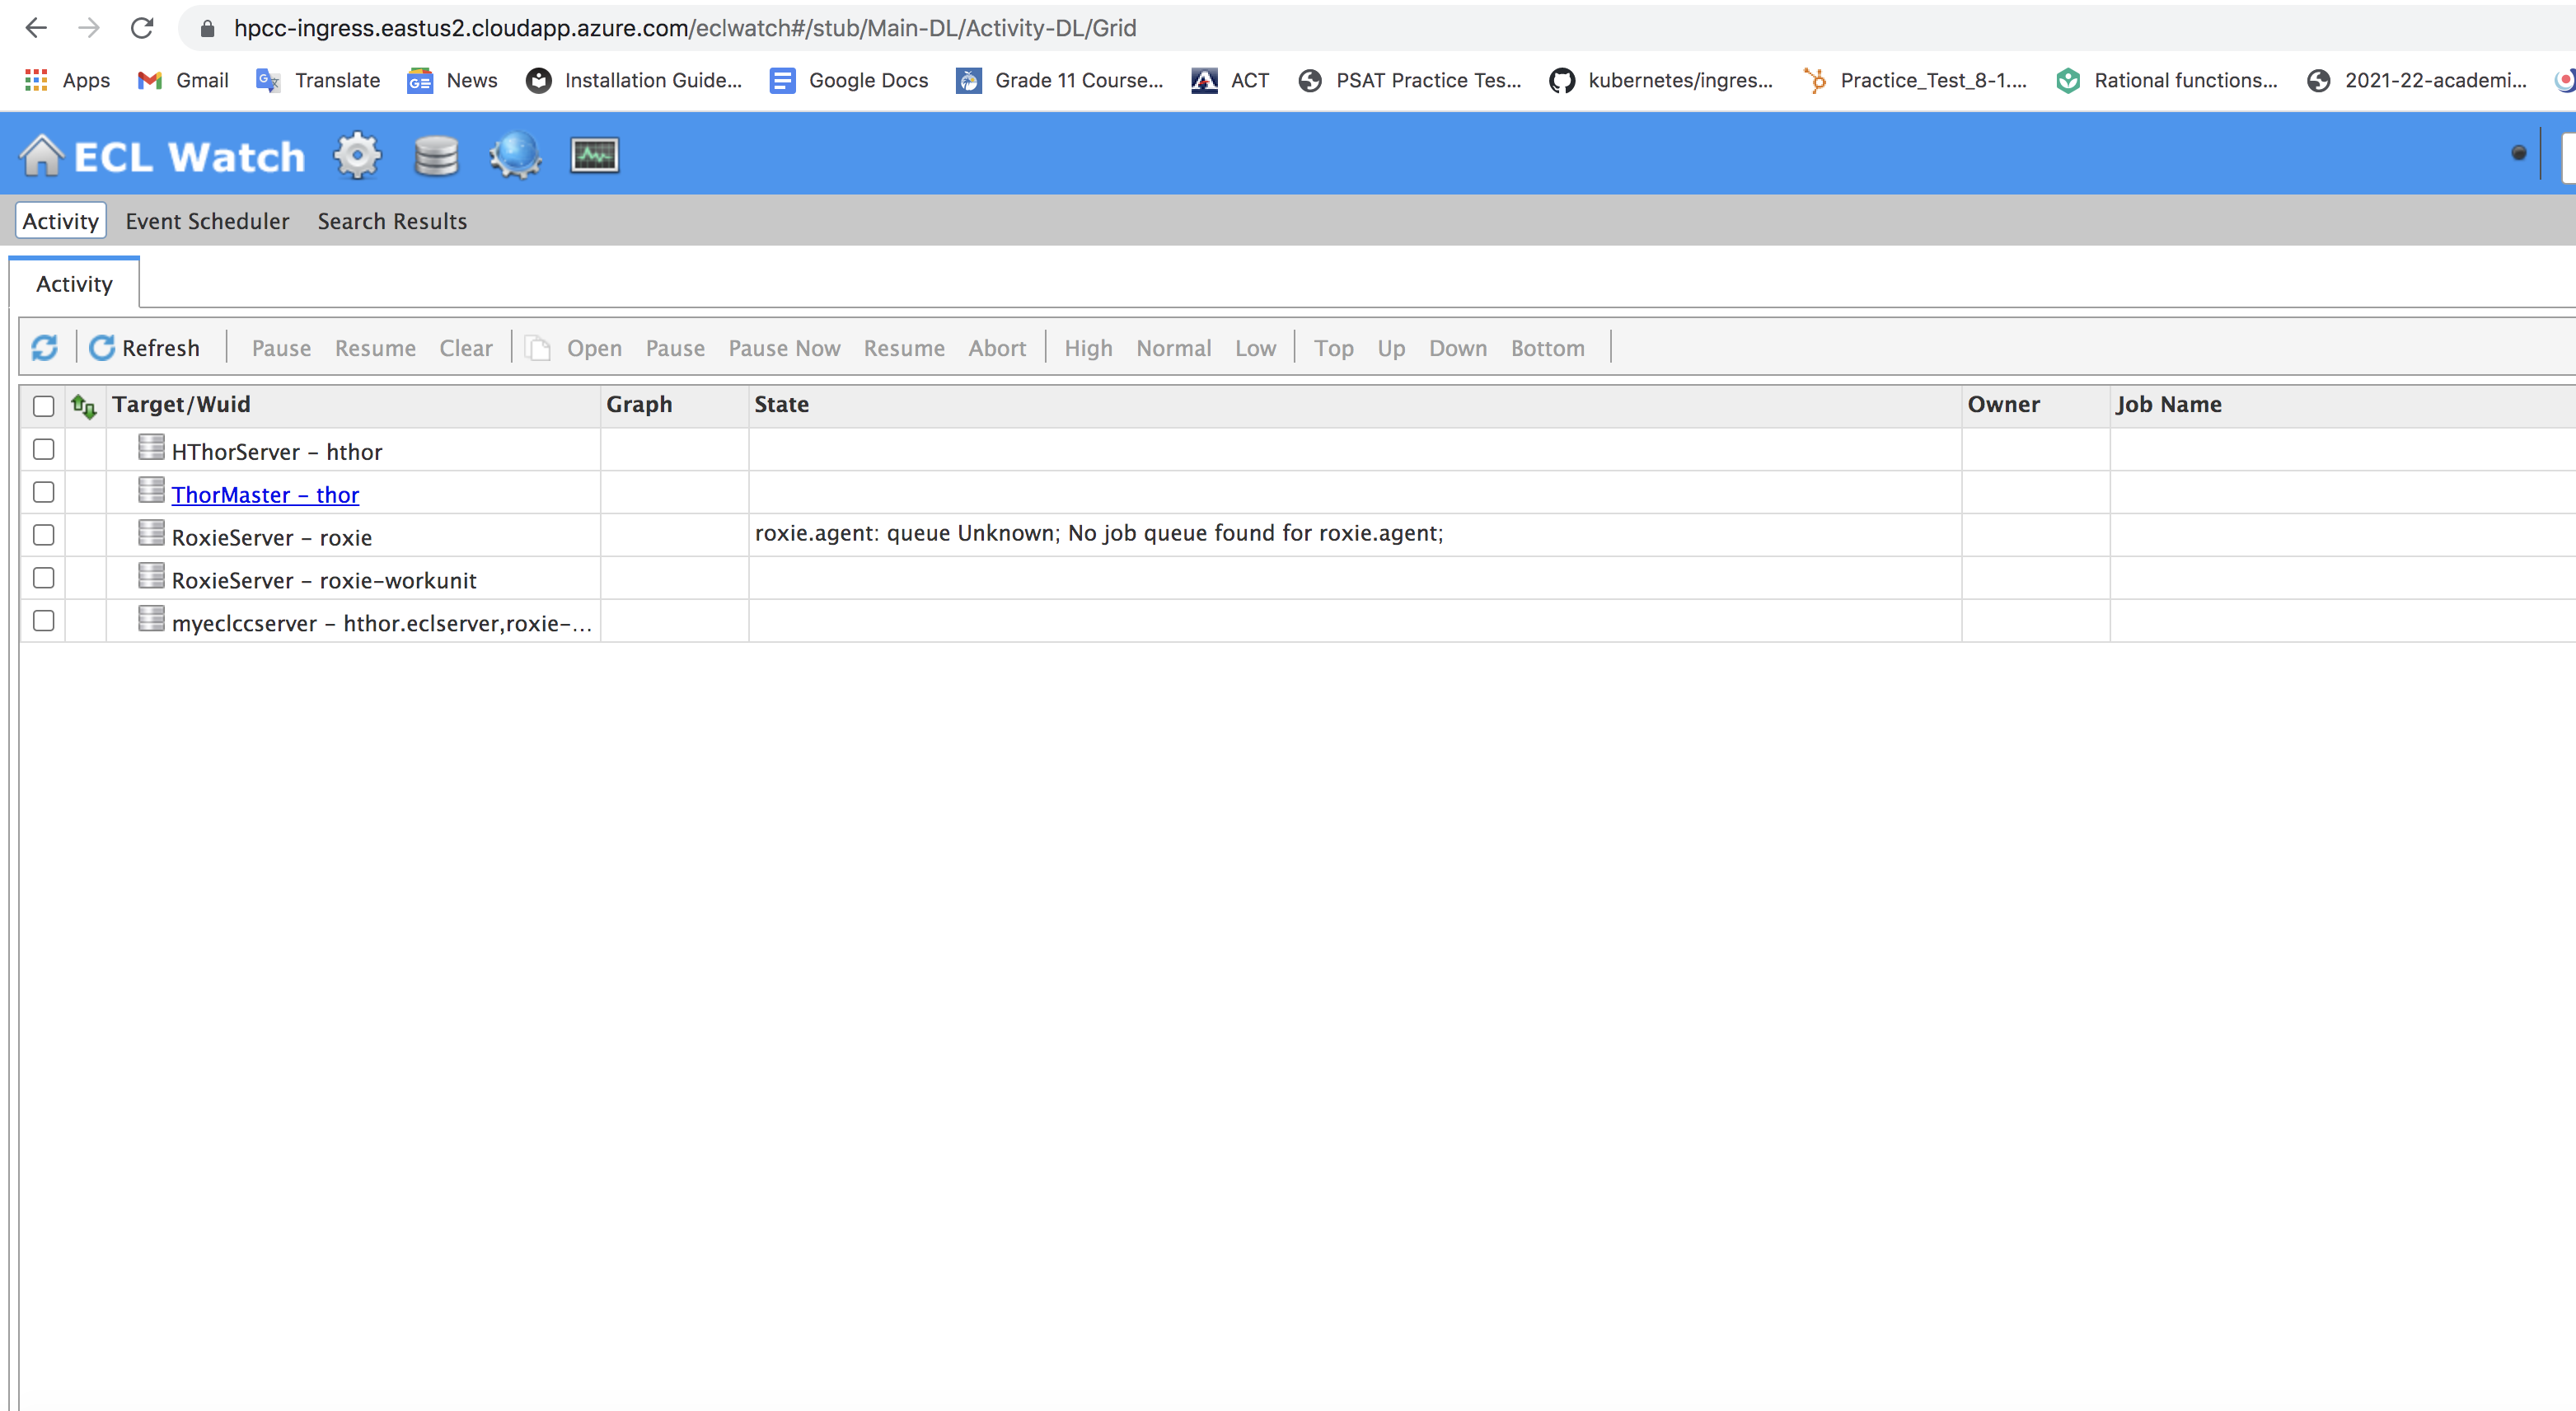

Finally, the ‘Certificate’ resource will be updated to reflect the state of the issuance process. You should be able to ‘describe’ the Certificate and see something like the below:

In [ ]:
kubectl describe certificate tls-secret

In [ ]:
Name:         tls-secret
Namespace:    default
Labels:       <none>
Annotations:  <none>
API Version:  cert-manager.io/v1
Kind:         Certificate
...
Spec:
  Dns Names:
    hpcc-ingress.eastus2.cloudapp.azure.com
  Issuer Ref:
    Group:      cert-manager.io
    Kind:       ClusterIssuer
    Name:       letsencrypt
  Secret Name:  tls-secret
  Usages:
    digital signature
    key encipherment
Status:
  Conditions:
    Last Transition Time:  2021-07-20T13:31:35Z
    Message:               Certificate is up to date and has not expired
    Observed Generation:   1
    Reason:                Ready
    Status:                True
    Type:                  Ready
  Not After:               2021-10-18T12:31:32Z
  Not Before:              2021-07-20T12:31:34Z
  Renewal Time:            2021-09-18T12:31:32Z
  Revision:                1
Events:                    <none>

The following is a picture of the certificate accessed from a web browser, and displays the Dns name, hpcc-ingress.eastus2.cloudapp.azure.com.

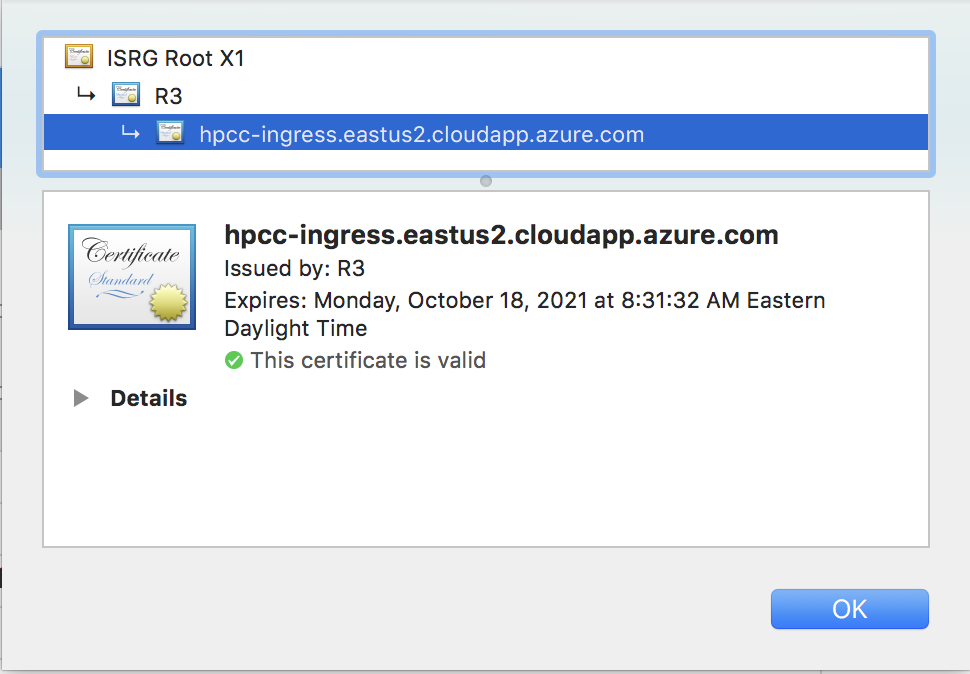

## Clean up resources

To delete the cluster issuer:

In [ ]:
kubectl delete -f cluster-issuer.yaml

List the Helm releases with the ```helm list``` command. Look for charts named nginx and cert-manager:

In [ ]:
helm list

In [ ]:
NAME                    NAMESPACE       REVISION        UPDATED                                 STATUS          CHART                   APP VERSION
cert-manager            DEFAULT         1               2020-01-15 10:23:36.515514 -0600 CST    deployed        cert-manager-v0.13.0    v0.13.0    
nginx                   DEFAULT         1               2020-01-15 10:09:45.982693 -0600 CST    deployed        nginx-ingress-1.29.1    0.27.0  

Uninstall the releases with the ```helm uninstall``` command. The following example uninstalls the NGINX ingress and cert-manager deployments.

In [ ]:
$ helm uninstall cert-manager nginx 

release "cert-manager" uninstalled
release "nginx" uninstalled

Remove the application:

In [ ]:
kubectl delete -f hpcc-ingress.yaml

Remove the ingress route that directed traffic to the sample apps:

In [ ]:
kubectl delete -f hpcc-ingress-route.yaml